In [1]:
import spacy, benepar, nltk
#benepar.download('benepar_en3')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pyperclip as clip

In [259]:
nlp = spacy.load('en_core_web_md')
if spacy.__version__.startswith('2'):
    nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"})

In [4]:
import sys
sys.path.append('../')
from FullParser.ClauseParser import ClauseParser
import pandas as pd

In [5]:
parser = ClauseParser()

In [6]:
def read_file(file_path):
    with open(file_path, 'r', encoding = 'utf-8') as f:
        for line in f:
            yield line

# Parser testing

In [144]:
def nlp_sent(sent):
    return list(nlp(sent).sents)[0]

In [145]:
def nlp_parse(sent):
    return nltk.Tree.fromstring(list(nlp(sent).sents)[0]._.parse_string).pretty_print()

In [343]:
# test_sent = "Bill told his friends about how he managed to climb everest"
# test_sent ="It was understood by most that we are here for fun"
# test_sent ="We need to think about what is needed to help us do both these things at the same time."
# test_sent = "I'm very aware of when I'm doing it nowadays"
# test_sent = "We are still unclear as to whether or not Canada is a state"
test_sent = "Bob knows that mary won the race and that Bill lost the race"
# test_sent = "Bob said to the person he loves that mary won the race and that Bill lost the race"
# test_sent = "You will totally see how real and honest they are about how they could forgive"
# test_sent = "Even his friends aren't sure whether he should come back, leading to a frank discussion of resurrection"
x = nlp_sent(test_sent)
nlp_parse(test_sent)
parser.parse_clauses(x)

                S                                                             
  ______________|_____________________                                         
 |                                    VP                                      
 |     _______________________________|____                                    
 |    |                                   SBAR                                
 |    |               _____________________|______________                     
 |    |             SBAR                   |             SBAR                 
 |    |     _________|____                 |     _________|____                
 |    |    |              S                |    |              S              
 |    |    |     _________|___             |    |     _________|___            
 |    |    |    |             VP           |    |    |             VP         
 |    |    |    |     ________|___         |    |    |     ________|___        
 NP   |    |    NP   |            NP       |  

/opt/homebrew/Caskroom/miniconda/base/envs/benepar_env/lib/python3.12/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


[{'sentence': 'Bob knows that mary won the race and that Bill lost the race',
  'predicate': [{'str': 'knows', 'lemma': 'know', 'POS': 'VERB'}],
  'type': 'declarative',
  'clause': 'that mary won the race'},
 {'sentence': 'Bob knows that mary won the race and that Bill lost the race',
  'predicate': [{'str': 'knows', 'lemma': 'know', 'POS': 'VERB'}],
  'type': 'declarative',
  'clause': 'that Bill lost the race'},
 {'sentence': 'Bob knows that mary won the race and that Bill lost the race',
  'predicate': [{'str': 'knows', 'lemma': 'know', 'POS': 'VERB'}],
  'type': 'declarative',
  'clause': 'that mary won the race and that Bill lost the race'}]

In [218]:
def flatten(xss):
    return [x for xs in xss for x in xs]
    
def get_last_predicate_tokens(span,sbar):
    if span == sbar:
        return []
    tokens = []
    for token in span:
        if token.i >= sbar[0].i:
            return tokens
        tokens.append(token)
    return tokens

# def get_last_predicate_tokens(span,sbar):
#         if span == sbar:
#              return []
#         children = list(span._.children)
#         tokens = []
#         if len(children)==0:
#             for t in span:
#                 if 'PUNCT' in t.pos_:
#                     return []
#             return [t for t in span]
#         for child in children:
#             if child == sbar:
#                 return tokens
#             else: 
#                 tokens += get_last_predicate_tokens(child,sbar)
#         return tokens

def check_PP_has_SBAR(PP_span,sbar):
    has_SBAR = False
    children = PP_span._.children
    for child in PP_span._.children:
        if 'PP' in child._.labels:
            has_SBAR = check_PP_has_SBAR(child,sbar) 
        if child == sbar:
            has_SBAR = True
            break
    return has_SBAR
        
def check_SBAR_match(token,sbar):
    parent = token._.parent
    if 'NP' in parent._.labels:
        return False
    if 'PP' in parent._.labels:
        return check_PP_has_SBAR(parent,sbar)
    if 'SBAR' in parent._.labels:
        return False
    return True
        

In [351]:
sbar_span = parser.get_SBAR_spans(x)[0]
pred_string = parser.test_pred_string(sbar_span)
VP_parent = parser.VP_parent_simple(sbar_span)

print(sbar_span)
print(pred_string)
print(VP_parent)
# parser.get_predicate(flatten([[t for t in child]for child in list(VP_parent._.children)[:-1] if not any([bad_label in child._.labels for bad_label in ['S','SBAR', 'NP', 'PP']])])+get_last_predicate_tokens(list(VP_parent._.children)[-1],sbar_span),sbar_span)
get_last_predicate_tokens(list(VP_parent._.children)[-1],sbar_span)
# [c._.labels for c in list(VP_parent._.children)]
# [(t,t._.parent._.labels,[ (child, str(child) in str(sbar_span) ) for child in (t._.parent._.children)]) for t in parser.test_pred_string(sbar_span)]
# [t for t in parser.test_pred_string(sbar_span) if not any([bad_label in t._.parent._.labels for bad_label in ['SBAR', 'NP']])]
# [[child for child in t._.parent._.children] for t in pred_string]
# [child for child in pred_string[-1]._.parent._.children]
# [(t,t._.parent._.labels, [child._.labels for child in t._.parent._.children]) for t in pred_string]
# [(t,t._.parent._.labels, t._.parent ) for t in pred_string]
# parser.get_predicate([t for t in pred_string if check_SBAR_match(t,sbar_span)])

that mary won the race and that Bill lost the race
knows that
knows that mary won the race and that Bill lost the race


True

In [192]:
sbar_span = parser.get_SBAR_spans(parser.get_SBAR_spans(x)[0])[0]
pred_string = parser.test_pred_string(sbar_span)
VP_parent = parser.VP_parent_simple(sbar_span)

print(sbar_span)
print(pred_string)
print(VP_parent)

get_last_predicate_tokens(list(VP_parent._.children)[-1],sbar_span)

# [(child,child._.labels) for child in VP_parent._.children]
# flatten([[t for t in child]for child in list(VP_parent._.children)[:-1] if not any([bad_label in child._.labels for bad_label in ['S','SBAR', 'NP', 'PP']])])+get_last_predicate_tokens(list(VP_parent._.children)[-1],sbar_span) 


# [(t,t._.parent._.labels,[ (child, str(child) in str(sbar_span) ) for child in (t._.parent._.children)]) for t in parser.test_pred_string(sbar_span)]
# [t for t in parser.test_pred_string(sbar_span) if not any([bad_label in t._.parent._.labels for bad_label in ['SBAR', 'NP']])]
# [[child for child in t._.parent._.children] for t in pred_string]
# [child for child in pred_string[-1]._.parent._.children]
# [(t,t._.parent._.labels, [child._.labels for child in t._.parent._.children]) for t in pred_string]
# [(t,t._.parent._.labels, list(t._.parent._.children)) for t in pred_string]
# parser.get_predicate([t for t in pred_string if check_SBAR_match(t,sbar_span)])

how they could forgive
are about how
are about how they could forgive


[about]

# Large Scale Data

In [159]:
# Fully processed sample of sample
# ECs = pd.concat([pd.read_json(f'./sample_parses/v1_5r2_sample-{str(i).zfill(4)}.txt.json') for i in range(103)])
new_ECs = pd.read_json('./v1_5r2_sample-0005.txt.json')

## Predicate Lemma distibution

In [160]:
# quick and dirty concatenation of predicate lemmas
# ECs['pred_lemmas'] = ECs['predicate'].apply(lambda x: ' '.join([pred['lemma'] for pred in x]))
new_ECs['pred_lemmas'] = new_ECs['predicate'].apply(lambda x: ' '.join([pred['lemma'] for pred in x]))
ECs_filtered = new_ECs[new_ECs['pred_lemmas'] != '']

<Axes: xlabel='pred_lemmas'>

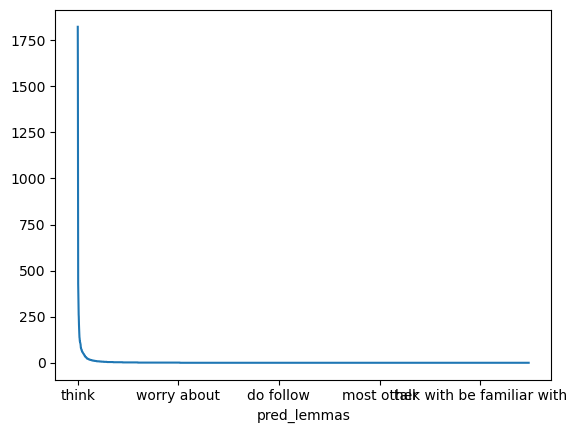

In [176]:
ECs_filtered.groupby('type').pred_lemmas.value_counts()['declarative'].plot.line()

In [342]:
conj = [
    "after", "although", "as", "as if", "as long as", "because",
    "before", "despite", "even if", "even though", "if", "in order that", "to",
    "rather", "since", "so that", "such that", "that", "though", "unless",
    "than","until", "when", "where", "whereas", "whether", "while"][26]

conj = "so"
new_ECs[new_ECs['clause'].apply(lambda x: conj in x[0:len(conj)] )]#.iloc[0]['sentence'])

,sentence,predicate,type,clause,pred_lemmas
126,Turn the person on one side so saliva can flow...,"[{'str': 'Turn', 'lemma': 'turn', 'POS': 'VERB...",declarative,so saliva can flow out of the mouth,turn on
132,"""We could then modify the procedure so that th...","[{'str': 'modify', 'lemma': 'modify', 'POS': '...",declarative,so that the toxin cured rather than killed,modify
148,"Question 5 Rewrite each sentence, beginning as...","[{'str': 'Rewrite', 'lemma': 'rewrite', 'POS':...",declarative,so that the meaning stays the same,rewrite begin show
152,"Question 6 Rewrite each sentence, beginning as...","[{'str': 'Rewrite', 'lemma': 'rewrite', 'POS':...",declarative,so that the meaning stays the same,rewrite begin show
219,Place 1st bracket so top flush with marks.,[],declarative,so top flush with marks,
...,...,...,...,...,...
37154,Usually I don’t need to use the bathroom so fr...,"[{'str': 'need', 'lemma': 'need', 'POS': 'VERB...",declarative,so it was quite surprised,need use
37171,M-Manage your workload so that you are able to...,[],declarative,so that you are able to balance your professio...,
37173,S-Sit pretty so that the world won’t be able t...,"[{'str': 'Sit', 'lemma': 'sit', 'POS': 'VERB'}]",declarative,so that the world won’t be able to see what li...,sit
37225,"Once it the top is flush with the side, make a...","[{'str': 'make', 'lemma': 'make', 'POS': 'VERB'}]",declarative,so that your paper looks like the one below,make


In [262]:
bl = ["after", "although", "before", "despite", "even if",
      "even though", "in order", "to", "for", "so that", 
      "such that", "though","unless","until",
      "than",'because', 'since', 'while', 'as']


[nlp(bl)[0].pos_ for bl in ['because', 'since', 'while', 'as', 'until', 'for','although']]


['SCONJ', 'SCONJ', 'SCONJ', 'ADP', 'ADP', 'ADP', 'SCONJ']

## MegaAcceptability comparisson

In [162]:
# Mega acceptability White & Rawlins 2016, 2020 An & White 2020
mega_v1 = pd.read_csv('/Users/s2518809/Downloads/mega-acceptability-v1/mega-acceptability-v1-normalized.tsv',sep='\t')

In [163]:
mega_v1_finite = mega_v1[mega_v1.frame.isin(['NP Ved that S', 'NP Ved S','NP was Ved that S', 'NP was Ved S',
                                                               'NP Ved whether S', 'NP Ved whichNP S',
                                                               'NP was Ved whether S', 'NP was Ved whichNP S'])]

mega_v1_finite_declarative_frames = mega_v1[mega_v1.frame.isin(['NP Ved that S', 'NP Ved S'])]

mega_v1_finite_constituent_frames = mega_v1[mega_v1.frame.isin(['NP Ved whichNP S'])]

In [164]:
mega_acceptabilities = mega_v1_finite.groupby('verb')['responsenorm'].max()
declarative_acceptabilities = mega_v1_finite_declarative_frames.groupby('verb')['responsenorm'].max()
constituent_acceptabilities = mega_v1_finite_constituent_frames.groupby('verb')['responsenorm'].max()

In [165]:
mega_verbs = set(mega_v1.verb.values)

Predicates found from MegaAcceptability

In [166]:
found_MA_preds = {pred for pred in set(new_ECs['pred_lemmas'].values) if pred in mega_verbs}
len(found_MA_preds)

440

In [167]:
declarative_ECs = new_ECs[new_ECs['type']=='declarative']
constituent_ECs = new_ECs[new_ECs['type']=='constituent']
found_MA_preds_declarative = {pred for pred in set(declarative_ECs['pred_lemmas'].values) if pred in mega_verbs}
found_MA_preds_constituent = {pred for pred in set(constituent_ECs['pred_lemmas'].values) if pred in mega_verbs}

In [168]:
MA_pred_counts = new_ECs[new_ECs['pred_lemmas'].apply(lambda x: x in found_MA_preds)]['pred_lemmas'].value_counts()
MA_pred_counts_declarative = declarative_ECs[declarative_ECs['pred_lemmas'].apply(lambda x: x in found_MA_preds)]['pred_lemmas'].value_counts()
MA_pred_counts_constituent = constituent_ECs[constituent_ECs['pred_lemmas'].apply(lambda x: x in found_MA_preds)]['pred_lemmas'].value_counts()

In [169]:
MA_pred_counts_full = pd.concat([pd.Series(0,index=mega_verbs.difference(set(MA_pred_counts.index))), MA_pred_counts])
MA_pred_counts_declarative_full = pd.concat([pd.Series(0,index=mega_verbs.difference(set(MA_pred_counts_declarative.index))), MA_pred_counts_declarative])
MA_pred_counts_constituent_full = pd.concat([pd.Series(0,index=mega_verbs.difference(set(MA_pred_counts_constituent.index))), MA_pred_counts_constituent])

### Correlation of frequency data with acceptability

In [170]:
print('Finite clauses correlation',mega_acceptabilities.corr(MA_pred_counts_full))
print('Declarative clauses correlation',declarative_acceptabilities.corr(MA_pred_counts_declarative_full))
print('Constituent clauses correlation',constituent_acceptabilities.corr(MA_pred_counts_constituent_full))

Finite clauses correlation 0.1550118041970863
Declarative clauses correlation 0.17143578555339367
Constituent clauses correlation 0.11164616665752561


In [180]:
MA_pred_counts_constituent_full

array([   0,    0,    0, ...,  271,  608, 1112])

## Analyzing Predicates beyond MA

In [171]:
# Predicates not in MegaAcceptability
extra_MA_preds = set(filter( lambda x: all(c.isalnum() for c in x), {pred for pred in set(new_ECs[new_ECs['predicate'].apply(lambda x: len(x)==1)]['pred_lemmas'].values) if pred not in mega_verbs}))
# Non-alphanimeric predicates
extra_MA_preds_nonan = set(filter( lambda x: any( not c.isalnum() for c in x), {pred for pred in set(new_ECs[new_ECs['predicate'].apply(lambda x: len(x)==1)]['pred_lemmas'].values) if pred not in mega_verbs}))
# complex predicates
complex_preds = set(new_ECs[new_ECs['predicate'].apply(lambda x: len(x)>1)]['pred_lemmas'].values)

In [172]:
'realize' in mega_verbs

True

In [173]:
extra_MA_pred_counts = new_ECs[new_ECs['pred_lemmas'].apply(lambda x: x in extra_MA_preds)]['pred_lemmas'].value_counts() 
extra_MA_pred_counts[50:70]

pred_lemmas
hide        12
visit       12
drop        12
break       12
win         11
join        11
achieve     11
enter       11
remove      11
complete    10
support     10
arrive      10
glad        10
improve     10
drink       10
live         9
exist        9
as           9
thought      9
arise        9
Name: count, dtype: int64

### Extraneous predicates from MA

Here we can look at the specific parses of the common predicates found outside of the the distribution

In [175]:
# Set the predicate we want to look at
weird_predicate = extra_MA_pred_counts.index[62]
print(f'Weird predicate: {weird_predicate}')
# Get a sentence from that weird predicate
weird_pred_sent = new_ECs[new_ECs['pred_lemmas'] == weird_predicate ].iloc[0]['sentence']
# Print syntactic tree
nlp_parse(weird_pred_sent)

Weird predicate: glad
                                      S                                       
   ___________________________________|_____________________________________   
  |             |                 |   |            S                        | 
  |             |                 |   |            |                        |  
  |             |                 |   |            VP                       | 
  |             |                 |   |    ________|___                     |  
  |             |                 |   |   |           ADJP                  | 
  |             |                 |   |   |    ________|______              |  
  |             |                 |   |   |   |              SBAR           | 
  |             |                 |   |   |   |               |             |  
  |             |                 |   |   |   |               S             | 
  |             |                 |   |   |   |     __________|_____        |  
  |             PP      

/opt/homebrew/Caskroom/miniconda/base/envs/benepar_env/lib/python3.12/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [493]:
# parser.parse_clauses(list(nlp(weird_pred_sent).sents)[0]) # Full Parse
new_ECs[new_ECs['pred_lemmas'] == weird_predicate ].iloc[15] # Entry

sentence       Christ is in you?--unless, indeed, you fail to...
predicate           [{'str': 'in', 'lemma': 'in', 'POS': 'ADP'}]
type                                                 declarative
clause           you?--unless, indeed, you fail to meet the test
pred_lemmas                                                   in
Name: 5806, dtype: object

In [480]:
test_sent = "What safeguards are in place that you eill respect the Penan's rights"
# nlp_parse(test_sent)
# parser.parse_clauses(list(nlp(test_sent).sents)[0])

[{'sentence': "What safeguards are in place that you eill respect the Penan's rights",
  'predicate': [{'str': 'in', 'lemma': 'in', 'POS': 'ADP'}],
  'type': 'declarative',
  'clause': "that you eill respect the Penan's rights"}]

In [458]:
clip.copy(weird_pred_sent)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Empty Predicate Parses
Lets look at the empty predicates in each category

In [613]:
## Declarative empty predicates
test = new_ECs[(new_ECs['pred_lemmas'] == '') & (new_ECs['type']== 'constituent')].iloc[2]
print(test)
tree = nltk.Tree.fromstring(list(nlp(test['sentence']).sents)[0]._.parse_string)
# Print the tree in ASCII
tree.pretty_print()

sentence       And then; "That is how we are different, Axinos.
predicate                                                    []
type                                                constituent
clause                             how we are different, Axinos
pred_lemmas                                                    
Name: 53, dtype: object
                           FRAG                                   
  __________________________|___________________________________   
 |   |    |   |        S                                        | 
 |   |    |   |    ____|____                                    |  
 |   |    |   |   |         VP                                  | 
 |   |    |   |   |     ____|_____                              |  
 |   |    |   |   |    |         SBAR                           | 
 |   |    |   |   |    |     _____|____                         |  
 |   |    |   |   |    |    |          S                        | 
 |   |    |   |   |    |    |      ____|______   

In [505]:
## Declarative empty predicates
test = new_ECs[(new_ECs['pred_lemmas'] == '') & (new_ECs['type']== 'declarative')][['sentence','clause']].iloc[1]['sentence']
tree = nltk.Tree.fromstring(list(nlp(test).sents)[0]._.parse_string)
# Print the tree in ASCII
tree.pretty_print()

                   S                                
  _________________|______________________________   
 |        VP                                      | 
 |    ____|___                                    |  
 |   |       SBAR                                 | 
 |   |        |                                   |  
 |   |        S                                   | 
 |   |     ___|_________                          |  
 |   |    |             VP                        | 
 |   |    |    _________|______________           |  
 NP  |    NP  |    |    |    |         NP         | 
 |   |    |   |    |    |    |     ____|____      |  
PRP VBP  PRP VBZ   RB   JJ   IN   DT       NNS    . 
 |   |    |   |    |    |    |    |         |     |  
 I  know she  ’s   so right  on these     points  . 



/opt/homebrew/Caskroom/miniconda/base/envs/benepar_env/lib/python3.12/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [48]:
# Function to get the top N elements of a list
def top_n(a,n):
    return np.flip(np.argsort(a)[-n:])

# Interrogative clauses

In [502]:
whether_ECs = pd.concat([pd.read_json(f'./whether_clauses/v1_5r2_sample_whether-{str(i).zfill(4)}.txt.json') for i in range(102)])

In [538]:
whether_ECs.shape

(5793, 5)

In [528]:
# quick and dirty concatenation of predicate lemmas
whether_ECs['pred_lemmas'] = whether_ECs['predicate'].apply(lambda x: ' '.join([pred['lemma'] for pred in x]))

In [544]:
whether_ECs.groupby('type')['pred_lemmas'].value_counts()['alternative']

pred_lemmas
care                      164
distinguish               102
go                        102
rely on of                 99
assess                     96
for                        96
leave                      92
choose                     88
forget                     87
matter                     82
actual                     68
on                         66
check                      64
be different in depend     60
decide                     43
adjust                     36
be unaware                  7
know                        5
Name: count, dtype: int64

In [539]:
whether_ECs.groupby('type')['pred_lemmas'].value_counts()['alternative']

pred_lemmas
care                      164
distinguish               102
go                        102
rely on of                 99
assess                     96
for                        96
leave                      92
choose                     88
forget                     87
matter                     82
actual                     68
on                         66
check                      64
be different in depend     60
decide                     43
adjust                     36
be unaware                  7
know                        5
Name: count, dtype: int64

In [540]:
## Declarative empty predicates
test = whether_ECs[(whether_ECs['pred_lemmas'] == 'welcome') & (whether_ECs['type']== 'polar')].iloc[0]
print(test)
tree = nltk.Tree.fromstring(list(nlp(test['sentence']).sents)[0]._.parse_string)
# Print the tree in ASCII
tree.pretty_print()

sentence       Dr Leon’s primary job scope is to welcome newc...
predicate      [{'str': 'welcome', 'lemma': 'welcome', 'POS':...
type                                                       polar
clause                               whether they like it or not
pred_lemmas                                              welcome
Name: 64, dtype: object
                                                          S                                                        
           _______________________________________________|______________________________________________________   
          |                                                            VP                                        | 
          |                      ______________________________________|_____                                    |  
          |                     |                                            S                                   | 
          |                     |                                    

/opt/homebrew/Caskroom/miniconda/base/envs/benepar_env/lib/python3.12/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
